### Setup 

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import shutil
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
import pandas as pd
import numpy as np
from sklearn import metrics

C:\Users\I863552\AppData\Local\Continuum\anaconda3\envs\fastai\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
PATH = '../data/science_bowl'

### Data inspection & validation set separation

In [4]:
def split_validation_set(ratio=0.2):
    if (not os.path.isdir(f'{PATH}/valid')):
        os.makedirs(f'{PATH}/valid', exist_ok=True)
        categories = os.listdir(f'{PATH}/train')
        for category in categories:
            os.makedirs(f'{PATH}/valid/{category}', exist_ok=True)
            category_filenames = os.listdir(f'{PATH}/train/{category}')
            file_counts = len(category_filenames)
            valid_counts = 0
            index = 0
            while (valid_counts / file_counts) < ratio:
                src = f'{PATH}/train/{category}/{category_filenames[index]}'
                dst = f'{PATH}/valid/{category}/{category_filenames[index]}'
                shutil.move(src, dst)
                index += 1
                valid_counts += 1

In [5]:
split_validation_set()

In [6]:
categories = os.listdir(f'{PATH}/train')
filename_sizes = []
for cat in categories:
    filenames = os.listdir(f'{PATH}/train/{cat}')
    for fn in filenames:
        filename_sizes.append(PIL.Image.open(f'{PATH}/train/{cat}/{fn}').size)
widths, heights = zip(*filename_sizes)

(array([16141.,  4502.,  1672.,   848.,   524.,   285.,   140.,    51.,    33.,    25.]),
 array([ 31. ,  70.3, 109.6, 148.9, 188.2, 227.5, 266.8, 306.1, 345.4, 384.7, 424. ]),
 <a list of 10 Patch objects>)

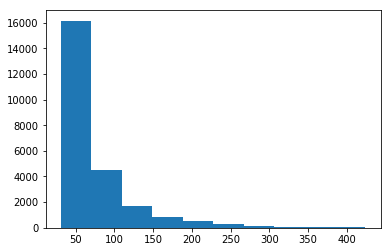

In [7]:
plt.hist(widths)

(array([15552.,  6025.,  1316.,   560.,   311.,   228.,   101.,    63.,    40.,    25.]),
 array([ 21. ,  61.7, 102.4, 143.1, 183.8, 224.5, 265.2, 305.9, 346.6, 387.3, 428. ]),
 <a list of 10 Patch objects>)

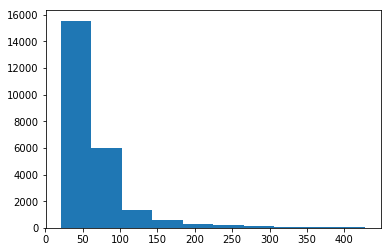

In [8]:
plt.hist(heights)

### Training 

In [9]:
arch = resnext101_64

In [10]:
def get_data(img_size=64):
    tfms = tfms_from_model(arch, img_size, aug_tfms=transforms_side_on + transforms_top_down, max_zoom=1.2)
    return ImageClassifierData.from_paths(f'{PATH}', tfms=tfms, test_name='test')

In [11]:
data = get_data(32)
learn = ConvLearner.pretrained(arch, data)

C:\Users\I863552\AppData\Local\Continuum\anaconda3\envs\fastai\lib\site-packages\fastai\initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)
C:\Users\I863552\AppData\Local\Continuum\anaconda3\envs\fastai\lib\site-packages\fastai\initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)


In [45]:
learn.lr_find()

 88%|████████████████████████████████████████████████████████████▉        | 335/379 [01:15<00:10,  4.21it/s, loss=13.7]

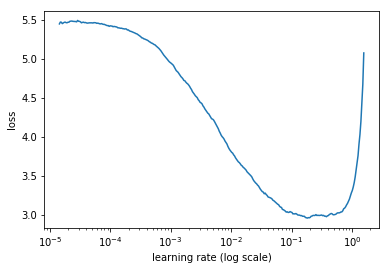

In [46]:
learn.sched.plot()

In [12]:
learning_rate = 2e-2

In [48]:
learn.fit(learning_rate, 2, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                                                                              
    0      2.072113   1.761281   0.524121  
    1      1.909753   1.602641   0.554865                                                                              


[1.6026412304560864, 0.5548650858553701]

In [49]:
learn.save('science_bowl_last_32')

In [50]:
learn.load('science_bowl_last_32')

In [51]:
log_preds, y = learn.TTA()
preds = np.mean(np.exp(log_preds), 0)
metrics.log_loss(y, preds)

1.5283163262586505

In [13]:
learning_rates = [learning_rate/100, learning_rate/3, learning_rate]

In [53]:
learn.unfreeze()

In [54]:
learn.fit(learning_rates, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                                                                              
    0      1.901038   1.561861   0.552903  
    1      1.790694   1.500347   0.568438                                                                              
    2      1.577415   1.331896   0.61341                                                                               
    3      1.604477   1.316428   0.616353                                                                              
    4      1.477142   1.227604   0.632216                                                                              
    5      1.335254   1.163646   0.652494                                                                              
    6      1.286935   1.133355   0.655274                                                                              


[1.1333551155770303, 0.655273916599442]

In [55]:
learn.save('science_bowl_full_32')

In [21]:
learn.load('science_bowl_full_32')

In [57]:
log_preds, y = learn.TTA()
preds = np.mean(np.exp(log_preds), 0)
metrics.log_loss(y, preds)

1.0741634389493318

In [22]:
learn.set_data(get_data(60))

In [23]:
learn.freeze()

In [24]:
learn.fit(learning_rate, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                                                                              
    0      1.633994   1.442609   0.58937   
    1      1.49771    1.312436   0.611938                                                                              
    2      1.472432   1.283258   0.625184                                                                              


[1.2832583083155111, 0.62518397383666]

In [25]:
learn.save('science_bowl_last_60')

In [26]:
learn.load('science_bowl_last_60')

In [27]:
log_preds, y = learn.TTA()
preds = np.mean(np.exp(log_preds), 0)
metrics.log_loss(y, preds)

1.2182858127220046

In [28]:
learn.unfreeze()

In [29]:
learn.fit(learning_rates, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                                                                              
    0      1.288873   1.06074    0.680294  
    1      1.234536   1.002733   0.690924                                                                              
    2      1.099032   0.952205   0.709076                                                                              
    3      1.175205   1.000097   0.691905                                                                              
    4      1.087967   1.071429   0.683729                                                                              
    5      1.011452   0.896444   0.725756                                                                              
    6      0.979244   0.875173   0.732298                                                                              


[0.8751728602929478, 0.7322976288182367]

In [30]:
learn.save('science_bowl_full_60')

In [41]:
learn.load('science_bowl_full_60')

In [32]:
log_preds, y = learn.TTA()
preds = np.mean(np.exp(log_preds), 0)
metrics.log_loss(y, preds)

0.8285863499759754

In [42]:
learn.unfreeze()

In [43]:
learn.fit(learning_rates, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                                                                              
    0      0.9912     0.874115   0.732625  
    1      1.031798   0.916435   0.724775                                                                              
    2      0.903586   0.860153   0.737531                                                                              
    3      0.994961   0.943333   0.709076                                                                              
    4      0.921105   0.844742   0.743254                                                                              
    5      0.860614   0.817903   0.744072                                                                              
    6      0.805841   0.801466   0.752576                                                                              


[0.8014656588179306, 0.7525756337242057]

In [44]:
log_preds, y = learn.TTA()
preds = np.mean(np.exp(log_preds), 0)
metrics.log_loss(y, preds)

0.75301044622538

In [45]:
learn.save('science_bowl_full_60')

In [46]:
learn.load('science_bowl_full_60')

In [47]:
learn.freeze()

In [48]:
learn.fit(learning_rate, 2, cycle_len=2)

epoch      trn_loss   val_loss   accuracy                                                                              
    0      0.774421   0.803524   0.751922  
    1      0.778534   0.79597    0.753884                                                                              
    2      0.773774   0.794444   0.752739                                                                              
    3      0.75676    0.794245   0.755029                                                                              


[0.7942453492789218, 0.7550286181788901]

In [49]:
learn.save('science_bowl_last_60_v2')

In [50]:
learn.load('science_bowl_last_60_v2')

In [51]:
log_preds, y = learn.TTA()
preds = np.mean(np.exp(log_preds), 0)
metrics.log_loss(y, preds)

0.7578011925411826

### Submit

In [52]:
log_preds, y = learn.TTA(is_test=True)
preds = np.mean(np.exp(log_preds), 0)

In [53]:
submit_df = pd.DataFrame(preds)
submit_df.head()

,0,1,2,3,4,5,6,7,8,9,...,111,112,113,114,115,116,117,118,119,120
0,2.606581e-03,4.416857e-05,0.000160,2.718759e-04,0.000174,1.989356e-03,8.410830e-04,8.787910e-04,2.998526e-02,8.314685e-04,...,9.622915e-03,7.348660e-05,7.143286e-04,4.966095e-04,1.660838e-04,5.958547e-05,1.175805e-04,4.950612e-02,3.257264e-02,0.004217
1,9.249127e-05,4.802224e-06,0.000021,1.405945e-05,0.000008,1.786661e-05,8.143355e-05,1.099765e-04,8.902589e-06,7.098395e-06,...,1.949330e-04,1.937162e-06,2.812011e-05,7.571453e-06,7.478124e-06,1.498823e-05,4.066806e-06,1.454615e-03,1.903448e-04,0.000240
2,8.516394e-07,7.596744e-07,0.000010,5.263508e-08,0.000001,3.484414e-08,5.479150e-07,3.676571e-08,1.902037e-07,4.249661e-07,...,2.097116e-07,1.374097e-07,3.049807e-07,3.063449e-08,6.720381e-08,1.054258e-07,7.306875e-08,1.980857e-07,1.618938e-07,0.000008
3,6.112621e-05,3.458264e-05,0.000012,8.993485e-05,0.000079,6.163259e-05,1.632786e-04,3.855018e-05,2.649199e-05,2.520707e-05,...,2.114883e-05,1.329095e-05,4.488393e-05,8.968076e-06,8.640799e-06,1.722641e-05,2.776372e-06,4.558141e-03,4.849955e-05,0.000443
4,1.700466e-05,3.188952e-05,0.000005,4.876396e-05,0.000003,4.077199e-06,6.335859e-06,1.640764e-06,6.603243e-06,6.439006e-06,...,4.597895e-04,1.302867e-05,1.143982e-05,2.884000e-05,2.079332e-05,2.034839e-06,1.646845e-05,8.054617e-04,1.505875e-04,0.000063


In [54]:
submit_df.columns = data.classes
submit_df.insert(0, 'image', [fn for fn in os.listdir(f'{PATH}/test')])
submit_df.head()

,image,acantharia_protist,acantharia_protist_big_center,acantharia_protist_halo,amphipods,appendicularian_fritillaridae,appendicularian_s_shape,appendicularian_slight_curve,appendicularian_straight,artifacts,...,trichodesmium_tuft,trochophore_larvae,tunicate_doliolid,tunicate_doliolid_nurse,tunicate_partial,tunicate_salp,tunicate_salp_chains,unknown_blobs_and_smudges,unknown_sticks,unknown_unclassified
0,1.jpg,2.606581e-03,4.416857e-05,0.000160,2.718759e-04,0.000174,1.989356e-03,8.410830e-04,8.787910e-04,2.998526e-02,...,9.622915e-03,7.348660e-05,7.143286e-04,4.966095e-04,1.660838e-04,5.958547e-05,1.175805e-04,4.950612e-02,3.257264e-02,0.004217
1,10.jpg,9.249127e-05,4.802224e-06,0.000021,1.405945e-05,0.000008,1.786661e-05,8.143355e-05,1.099765e-04,8.902589e-06,...,1.949330e-04,1.937162e-06,2.812011e-05,7.571453e-06,7.478124e-06,1.498823e-05,4.066806e-06,1.454615e-03,1.903448e-04,0.000240
2,100.jpg,8.516394e-07,7.596744e-07,0.000010,5.263508e-08,0.000001,3.484414e-08,5.479150e-07,3.676571e-08,1.902037e-07,...,2.097116e-07,1.374097e-07,3.049807e-07,3.063449e-08,6.720381e-08,1.054258e-07,7.306875e-08,1.980857e-07,1.618938e-07,0.000008
3,1000.jpg,6.112621e-05,3.458264e-05,0.000012,8.993485e-05,0.000079,6.163259e-05,1.632786e-04,3.855018e-05,2.649199e-05,...,2.114883e-05,1.329095e-05,4.488393e-05,8.968076e-06,8.640799e-06,1.722641e-05,2.776372e-06,4.558141e-03,4.849955e-05,0.000443
4,10000.jpg,1.700466e-05,3.188952e-05,0.000005,4.876396e-05,0.000003,4.077199e-06,6.335859e-06,1.640764e-06,6.603243e-06,...,4.597895e-04,1.302867e-05,1.143982e-05,2.884000e-05,2.079332e-05,2.034839e-06,1.646845e-05,8.054617e-04,1.505875e-04,0.000063


In [55]:
submit_df.to_csv(f'submit/plankton.gz', compression='gzip', index=False)
FileLink(f'submit/plankton.gz')

C:\Users\I863552\Documents\fastai\courses\dl1\kaggle\submit\plankton.gz